# PointNet: 3D Point Cloud Classification

This notebook implements the [PointNet](https://arxiv.org/abs/1612.00593) architecture from scratch in PyTorch for 3D point cloud classification on LiDAR scan data.

The project follows a staged progression, building from a simple baseline to a full PointNet implementation with spatial transformers, and includes utilities for model analysis and visualization.

## Setup

In [3]:
import sys
sys.path.insert(0, 'src')

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

In [48]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = True
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU enabled.
Using device: mps


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [6]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Data Loading

This section implements the PyTorch Dataset class, 'Argoverse', to efficiently load and pre-process the 3D point cloud data. It handles the train/test splits and pads all point clouds to a uniform size (200 points).

In [7]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [9]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

In [14]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [15]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


In [16]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=10, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 213.29it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 241.41it/s]



Epoch 1 Stats:
	Training accuracy: 0.7553
	Training loss: 0.7272
	Validation accuracy: 0.4867
	Validation loss: 3.3264

Validation accuracy improved from 0 to 0.4866666793823242
Saving model to Baseline.pt


Epoch 2

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 374.57it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 430.54it/s]



Epoch 2 Stats:
	Training accuracy: 0.7526
	Training loss: 0.7528
	Validation accuracy: 0.4733
	Validation loss: 3.3551


Epoch 3

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 383.07it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 438.28it/s]



Epoch 3 Stats:
	Training accuracy: 0.7471
	Training loss: 0.7785
	Validation accuracy: 0.4800
	Validation loss: 3.3442


Epoch 4

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 387.79it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 432.57it/s]



Epoch 4 Stats:
	Training accuracy: 0.7597
	Training loss: 0.7411
	Validation accuracy: 0.5150
	Validation loss: 3.0960

Validation accuracy improved from 0.4866666793823242 to 0.5149999856948853
Saving model to Baseline.pt


Epoch 5

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 405.75it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 456.87it/s]



Epoch 5 Stats:
	Training accuracy: 0.7444
	Training loss: 0.7664
	Validation accuracy: 0.4983
	Validation loss: 3.4734


Epoch 6

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 387.56it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 452.81it/s]



Epoch 6 Stats:
	Training accuracy: 0.7474
	Training loss: 0.7709
	Validation accuracy: 0.4767
	Validation loss: 3.4117


Epoch 7

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 393.98it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 450.49it/s]



Epoch 7 Stats:
	Training accuracy: 0.7556
	Training loss: 0.7345
	Validation accuracy: 0.4983
	Validation loss: 3.1894


Epoch 8

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 343.15it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 436.19it/s]



Epoch 8 Stats:
	Training accuracy: 0.7435
	Training loss: 0.7937
	Validation accuracy: 0.5317
	Validation loss: 3.0790

Validation accuracy improved from 0.5149999856948853 to 0.5316666960716248
Saving model to Baseline.pt


Epoch 9

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 397.05it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 440.97it/s]



Epoch 9 Stats:
	Training accuracy: 0.7576
	Training loss: 0.7230
	Validation accuracy: 0.4900
	Validation loss: 3.1820


Epoch 10

Training...


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 403.61it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 426.11it/s]


Epoch 10 Stats:
	Training accuracy: 0.7556
	Training loss: 0.7830
	Validation accuracy: 0.5300
	Validation loss: 3.0829




In [32]:
model = torch.load('output/Baseline.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 228.41it/s]

Test accuracy: 0.5317
Test loss: 3.0575


## PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well.

In [14]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [15]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


In [16]:
lr = 0.001
weight_decay = 1e-4
epochs = 15

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [17]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 54.73it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 175.07it/s]



Epoch 1 Stats:
	Training accuracy: 0.3124
	Training loss: 1.9699
	Validation accuracy: 0.3017
	Validation loss: 2.0590

Validation accuracy improved from 0 to 0.3016666769981384
Saving model to PointNet.pt


Epoch 2

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 117.90it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 268.99it/s]



Epoch 2 Stats:
	Training accuracy: 0.5241
	Training loss: 1.3903
	Validation accuracy: 0.4333
	Validation loss: 1.7242

Validation accuracy improved from 0.3016666769981384 to 0.4333333373069763
Saving model to PointNet.pt


Epoch 3

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 106.66it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 255.75it/s]



Epoch 3 Stats:
	Training accuracy: 0.6071
	Training loss: 1.1529
	Validation accuracy: 0.5000
	Validation loss: 1.5206

Validation accuracy improved from 0.4333333373069763 to 0.5
Saving model to PointNet.pt


Epoch 4

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 113.94it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 240.63it/s]



Epoch 4 Stats:
	Training accuracy: 0.6579
	Training loss: 1.0338
	Validation accuracy: 0.5000
	Validation loss: 1.5647


Epoch 5

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 116.24it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 305.17it/s]



Epoch 5 Stats:
	Training accuracy: 0.6826
	Training loss: 0.9448
	Validation accuracy: 0.5600
	Validation loss: 1.2909

Validation accuracy improved from 0.5 to 0.5600000023841858
Saving model to PointNet.pt


Epoch 6

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 120.71it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 313.43it/s]



Epoch 6 Stats:
	Training accuracy: 0.7206
	Training loss: 0.8499
	Validation accuracy: 0.5200
	Validation loss: 1.4260


Epoch 7

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 125.21it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 308.47it/s]



Epoch 7 Stats:
	Training accuracy: 0.7474
	Training loss: 0.7484
	Validation accuracy: 0.5917
	Validation loss: 1.1964

Validation accuracy improved from 0.5600000023841858 to 0.5916666388511658
Saving model to PointNet.pt


Epoch 8

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 124.52it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 302.10it/s]



Epoch 8 Stats:
	Training accuracy: 0.7521
	Training loss: 0.7324
	Validation accuracy: 0.5600
	Validation loss: 1.3581


Epoch 9

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 124.50it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 313.89it/s]



Epoch 9 Stats:
	Training accuracy: 0.7871
	Training loss: 0.6478
	Validation accuracy: 0.5833
	Validation loss: 1.3449


Epoch 10

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 125.21it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 306.38it/s]



Epoch 10 Stats:
	Training accuracy: 0.7835
	Training loss: 0.6539
	Validation accuracy: 0.5617
	Validation loss: 1.3190


Epoch 11

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 126.63it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 314.40it/s]



Epoch 11 Stats:
	Training accuracy: 0.7968
	Training loss: 0.5869
	Validation accuracy: 0.6017
	Validation loss: 1.1956

Validation accuracy improved from 0.5916666388511658 to 0.6016666889190674
Saving model to PointNet.pt


Epoch 12

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 124.35it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 311.12it/s]



Epoch 12 Stats:
	Training accuracy: 0.8253
	Training loss: 0.5206
	Validation accuracy: 0.6167
	Validation loss: 1.2805

Validation accuracy improved from 0.6016666889190674 to 0.6166666746139526
Saving model to PointNet.pt


Epoch 13

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 121.51it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 288.45it/s]



Epoch 13 Stats:
	Training accuracy: 0.8147
	Training loss: 0.5498
	Validation accuracy: 0.5417
	Validation loss: 1.4934


Epoch 14

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 116.08it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 229.68it/s]



Epoch 14 Stats:
	Training accuracy: 0.8391
	Training loss: 0.4624
	Validation accuracy: 0.6267
	Validation loss: 1.1711

Validation accuracy improved from 0.6166666746139526 to 0.6266666650772095
Saving model to PointNet.pt


Epoch 15

Training...


100%|████████████████████████████████████████| 213/213 [00:01<00:00, 120.60it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 294.83it/s]



Epoch 15 Stats:
	Training accuracy: 0.8394
	Training loss: 0.4757
	Validation accuracy: 0.6033
	Validation loss: 1.4523




In [18]:
model = torch.load('output/PointNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 76.35it/s]

Test accuracy: 0.6267
Test loss: 1.1735


## Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

In [36]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [37]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


We use the confusion matrix to look at which mistakes our model is making most often.

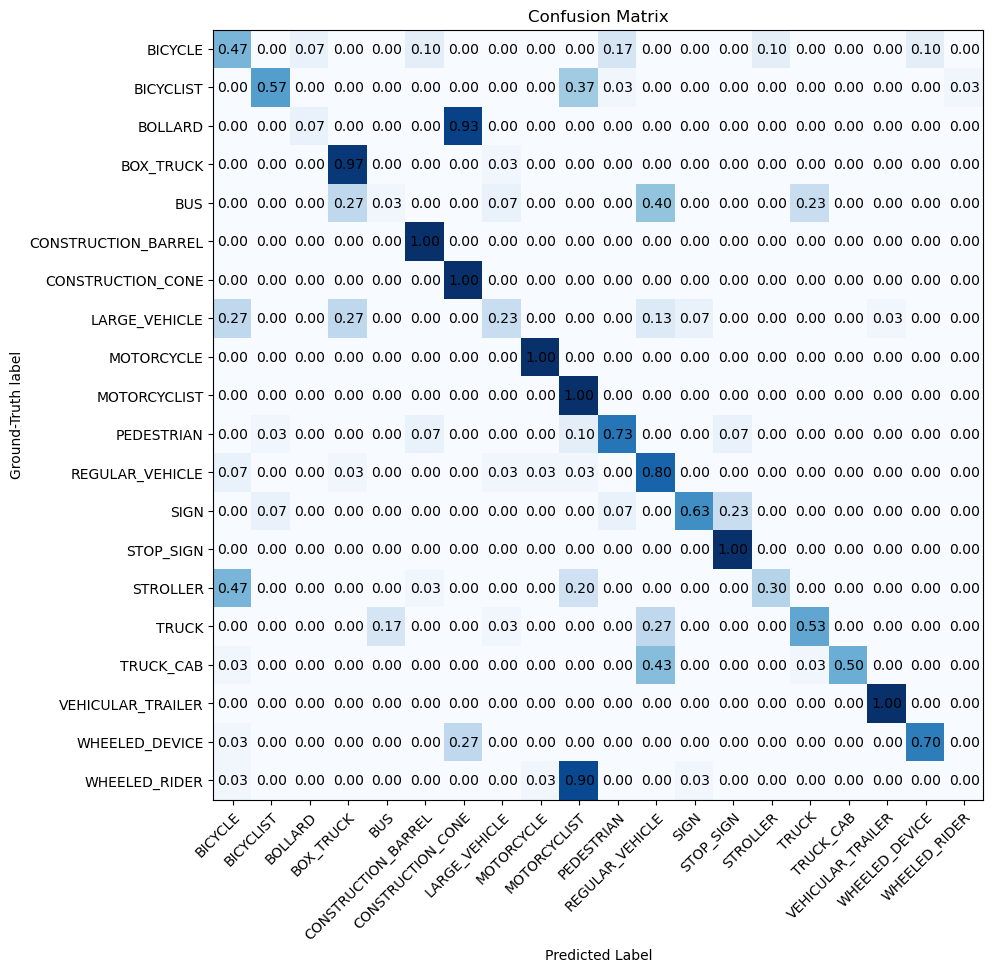

In [34]:
model = torch.load('output/PointNet.pt', weights_only=False)

model.to(device) 

generate_and_plot_confusion_matrix(model, test_loader, 20, device=device)

Now we visualize the critical points calculated by our model for the predestrian clouds from before.

In [35]:
plot_crit_points_from_file(model, 'data/sweeps/BUS/11.txt', 200)

## T-Net

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

In [38]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [39]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


We will check out how our model performs now that we added a T-Net.

In [59]:
lr = 0.001
weight_decay = 5e-4
epochs = 18

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [60]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 58.30it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 146.35it/s]



Epoch 1 Stats:
	Training accuracy: 0.2571
	Training loss: 2.1378
	Validation accuracy: 0.2983
	Validation loss: 1.8310

Validation accuracy improved from 0 to 0.2983333468437195
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 64.61it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 129.34it/s]



Epoch 2 Stats:
	Training accuracy: 0.4921
	Training loss: 1.4854
	Validation accuracy: 0.4083
	Validation loss: 1.7691

Validation accuracy improved from 0.2983333468437195 to 0.40833333134651184
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 62.67it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 160.20it/s]



Epoch 3 Stats:
	Training accuracy: 0.5876
	Training loss: 1.2180
	Validation accuracy: 0.4867
	Validation loss: 1.4940

Validation accuracy improved from 0.40833333134651184 to 0.4866666793823242
Saving model to PointNetTNet.pt


Epoch 4

Training...


100%|█████████████████████████████████████████| 213/213 [00:04<00:00, 50.10it/s]



Testing...


100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 86.21it/s]



Epoch 4 Stats:
	Training accuracy: 0.6388
	Training loss: 1.0246
	Validation accuracy: 0.5767
	Validation loss: 1.3145

Validation accuracy improved from 0.4866666793823242 to 0.5766666531562805
Saving model to PointNetTNet.pt


Epoch 5

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 59.56it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 120.43it/s]



Epoch 5 Stats:
	Training accuracy: 0.6897
	Training loss: 0.9135
	Validation accuracy: 0.5567
	Validation loss: 1.2724


Epoch 6

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 61.40it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 104.15it/s]



Epoch 6 Stats:
	Training accuracy: 0.7171
	Training loss: 0.8355
	Validation accuracy: 0.5617
	Validation loss: 1.2305


Epoch 7

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 61.80it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 164.20it/s]



Epoch 7 Stats:
	Training accuracy: 0.7474
	Training loss: 0.7552
	Validation accuracy: 0.6033
	Validation loss: 1.4119

Validation accuracy improved from 0.5766666531562805 to 0.6033333539962769
Saving model to PointNetTNet.pt


Epoch 8

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 59.05it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 171.25it/s]



Epoch 8 Stats:
	Training accuracy: 0.7579
	Training loss: 0.7363
	Validation accuracy: 0.5683
	Validation loss: 1.3818


Epoch 9

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 60.83it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 165.55it/s]



Epoch 9 Stats:
	Training accuracy: 0.7856
	Training loss: 0.6309
	Validation accuracy: 0.5867
	Validation loss: 1.1572


Epoch 10

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 59.95it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 161.50it/s]



Epoch 10 Stats:
	Training accuracy: 0.7879
	Training loss: 0.6257
	Validation accuracy: 0.5467
	Validation loss: 1.4520


Epoch 11

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 60.98it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 128.23it/s]



Epoch 11 Stats:
	Training accuracy: 0.8035
	Training loss: 0.5913
	Validation accuracy: 0.5767
	Validation loss: 1.3943


Epoch 12

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 63.64it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 182.02it/s]



Epoch 12 Stats:
	Training accuracy: 0.8056
	Training loss: 0.5656
	Validation accuracy: 0.5900
	Validation loss: 1.4136


Epoch 13

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 62.33it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 163.19it/s]



Epoch 13 Stats:
	Training accuracy: 0.8224
	Training loss: 0.5476
	Validation accuracy: 0.6450
	Validation loss: 1.1853

Validation accuracy improved from 0.6033333539962769 to 0.6449999809265137
Saving model to PointNetTNet.pt


Epoch 14

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 54.77it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 138.50it/s]



Epoch 14 Stats:
	Training accuracy: 0.8256
	Training loss: 0.5134
	Validation accuracy: 0.5250
	Validation loss: 1.6978


Epoch 15

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 54.66it/s]



Testing...


100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 86.48it/s]



Epoch 15 Stats:
	Training accuracy: 0.8426
	Training loss: 0.4914
	Validation accuracy: 0.5900
	Validation loss: 1.2650


Epoch 16

Training...


100%|█████████████████████████████████████████| 213/213 [00:04<00:00, 48.91it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 130.59it/s]



Epoch 16 Stats:
	Training accuracy: 0.8353
	Training loss: 0.4890
	Validation accuracy: 0.6683
	Validation loss: 1.1731

Validation accuracy improved from 0.6449999809265137 to 0.6683333516120911
Saving model to PointNetTNet.pt


Epoch 17

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 57.32it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 129.14it/s]



Epoch 17 Stats:
	Training accuracy: 0.8326
	Training loss: 0.4900
	Validation accuracy: 0.6133
	Validation loss: 1.1817


Epoch 18

Training...


100%|█████████████████████████████████████████| 213/213 [00:03<00:00, 57.06it/s]



Testing...


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 128.34it/s]



Epoch 18 Stats:
	Training accuracy: 0.8406
	Training loss: 0.4655
	Validation accuracy: 0.6000
	Validation loss: 1.1975




In [61]:
model = torch.load('output/PointNetTNet.pt', weights_only=False)
model = model.to(device)
test_acc, test_loss = test(model, test_loader, device=device)

100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 67.27it/s]


Test accuracy: 0.6683
Test loss: 1.1873


Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model.

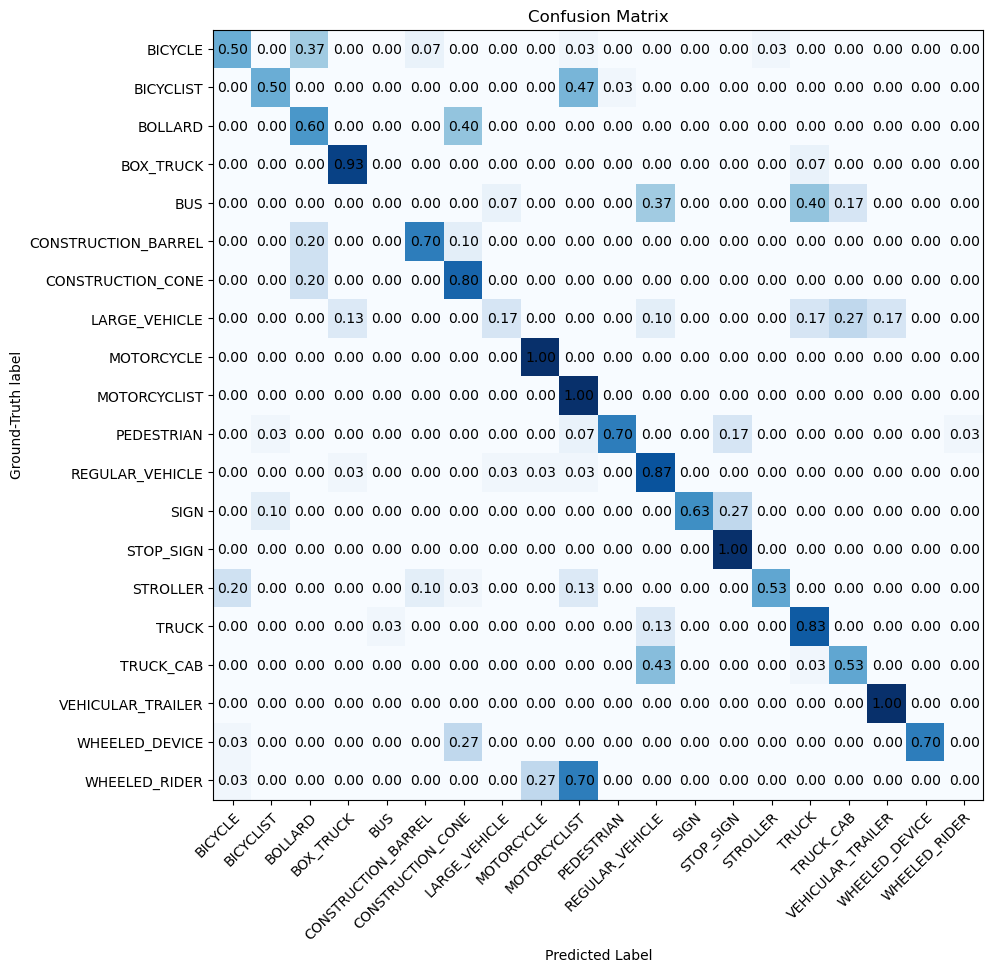

In [55]:
generate_and_plot_confusion_matrix(model, test_loader, 20, device=device)

In [42]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)